In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

# 配色方案
colors_primary = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
colors_weather = {
    'Clear': '#ffd700',    
    'Clouds': '#e0e0e0',  
    'Rain': '#6495ed',     
    'Snow': '#f0f8ff',     
    'Drizzle': '#b0e0e6',  
    'Thunderstorm': '#4b0082'  
}

In [2]:
df = pd.read_csv('C://Users//15222//Desktop//Metro_Interstate_Traffic_Volume.csv', encoding='utf-8')
# 查看数据基本信息
print("\n数据前5行：")
print(df.head())
print("\n数据类型：")
print(df.dtypes)
print("\n缺失值统计：")
print(df.isnull().sum())

# 数据预处理
# 转换日期格式
df['date_time'] = pd.to_datetime(df['date_time'])

# 提取时间维度特征
df['year'] = df['date_time'].dt.year  
df['month'] = df['date_time'].dt.month  
df['day'] = df['date_time'].dt.day  
df['hour'] = df['date_time'].dt.hour  
df['weekday'] = df['date_time'].dt.dayofweek  
df['weekday_cn'] = df['weekday'].map({0:'周一',1:'周二',2:'周三',3:'周四',4:'周五',5:'周六',6:'周日'})
df['month_cn'] = df['month'].map({1:'1月',2:'2月',3:'3月',4:'4月',5:'5月',6:'6月',7:'7月',8:'8月',9:'9月',10:'10月',11:'11月',12:'12月'})

# 天气特征简化（合并相似天气类型）
df['weather_simple'] = df['weather_main'].replace({
    'Drizzle': 'Rain',  # 小雨归为雨天
    'Thunderstorm': 'Rain'  # 雷雨归为雨天
})

# 异常值过滤
df = df[df['traffic_volume'] > 0]


数据前5行：
  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  

数据类型：
holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time        

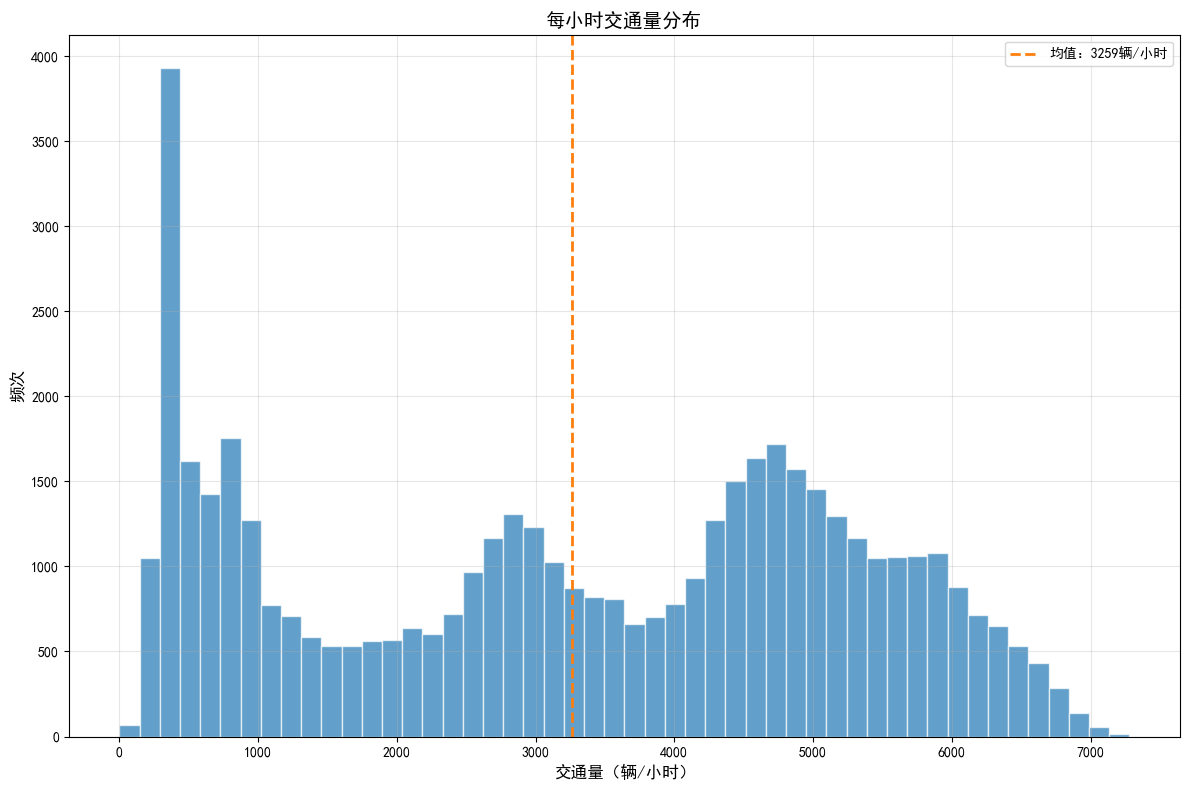

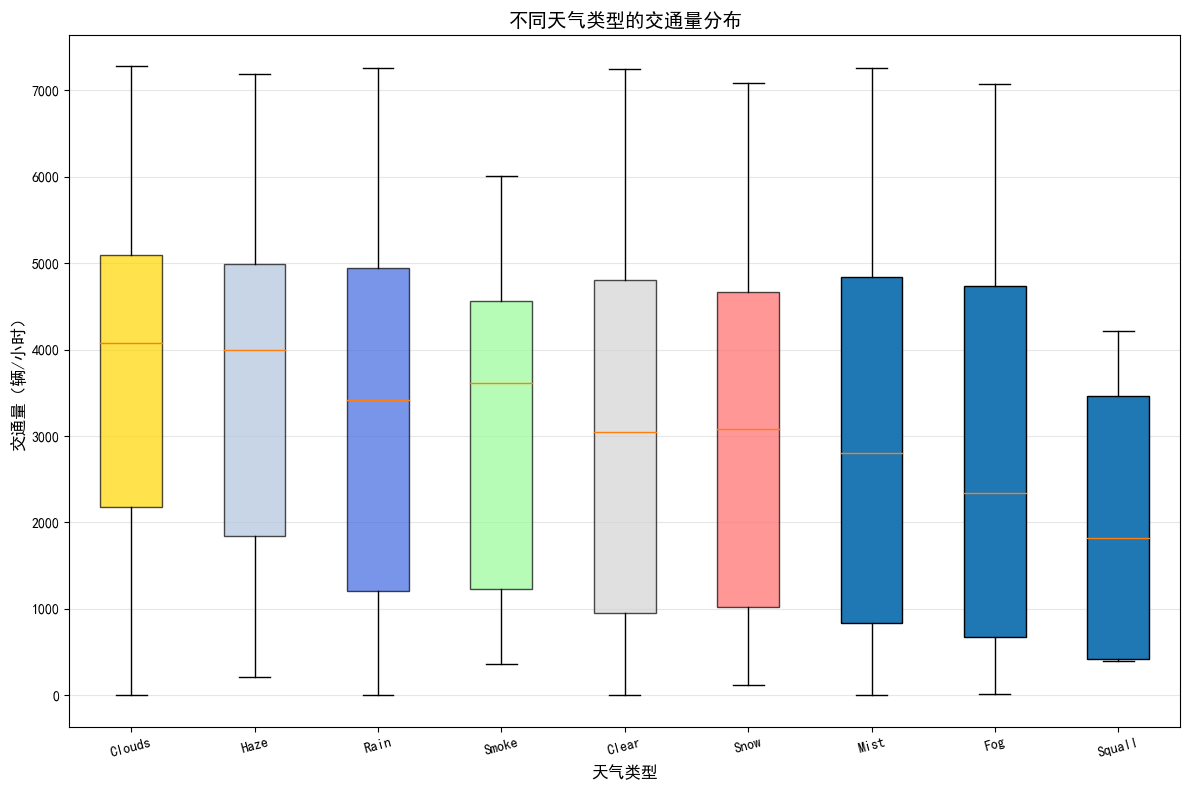

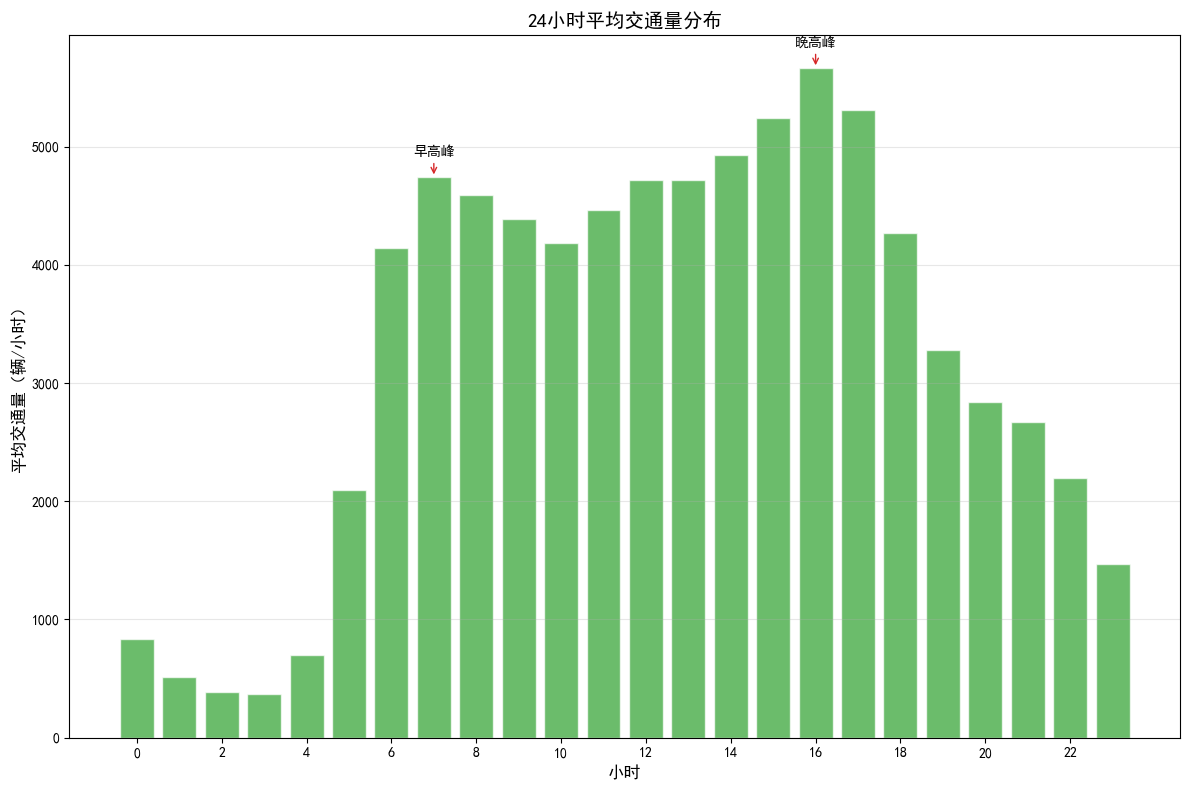

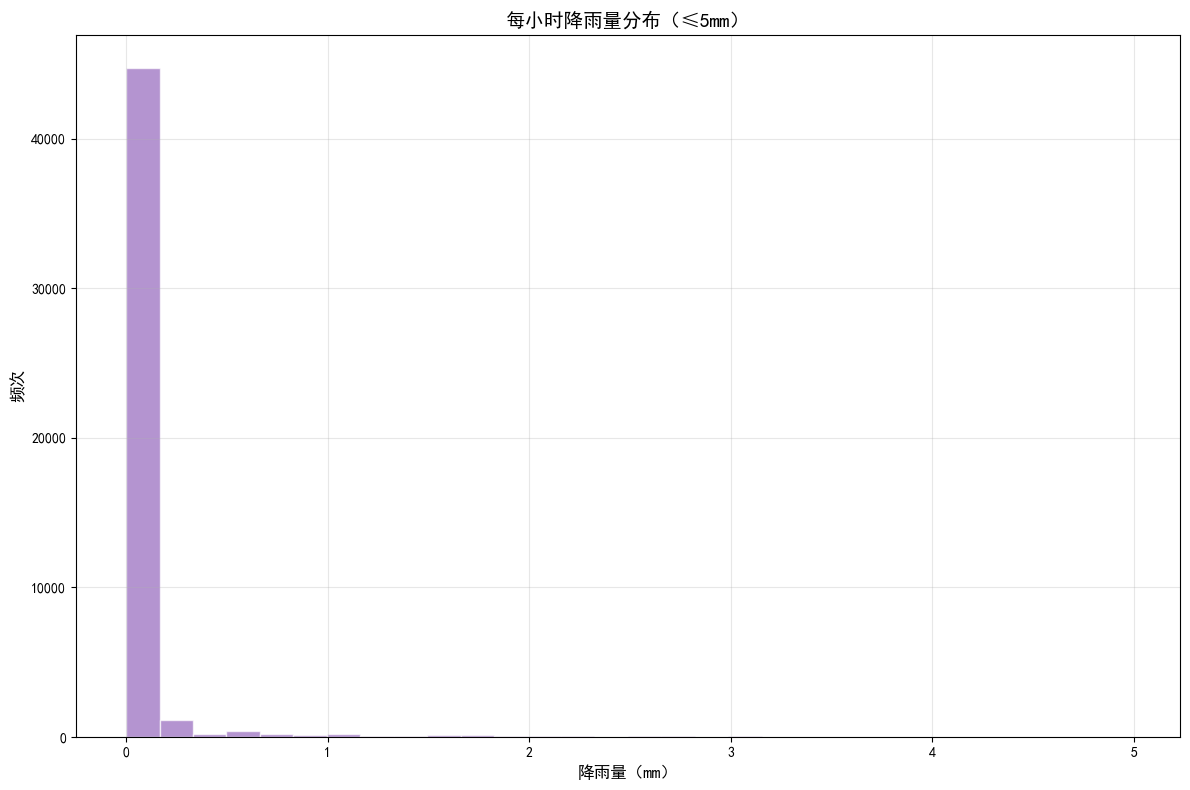

In [3]:
# 每小时交通量分布
plt.figure(figsize=(12, 8))  
plt.hist(df['traffic_volume'], bins=50, color=colors_primary[0], alpha=0.7, edgecolor='white')
plt.title('每小时交通量分布', fontweight='bold', fontsize=14)
plt.xlabel('交通量（辆/小时）', fontsize=12)
plt.ylabel('频次', fontsize=12)
plt.grid(alpha=0.3)

# 添加均值线
mean_volume = df['traffic_volume'].mean()
plt.axvline(mean_volume, color=colors_primary[1], linewidth=2, linestyle='--', 
            label=f'均值：{int(mean_volume)}辆/小时')
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# 不同天气类型的交通量分布
plt.figure(figsize=(12, 8))
weather_order = df.groupby('weather_simple')['traffic_volume'].mean().sort_values(ascending=False).index
box_data = [df[df['weather_simple']==w]['traffic_volume'] for w in weather_order]
unique_box_colors = ['#FFD700', '#B0C4DE', '#4169E1', '#98FB98', '#D3D3D3', '#FF6B6B']
box_colors = unique_box_colors[:len(weather_order)]

bp = plt.boxplot(box_data, labels=weather_order, patch_artist=True)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('不同天气类型的交通量分布', fontweight='bold', fontsize=14)
plt.xlabel('天气类型', fontsize=12)
plt.ylabel('交通量（辆/小时）', fontsize=12)
plt.grid(alpha=0.3, axis='y')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

# 一天中不同小时的交通量分布
plt.figure(figsize=(12, 8))
hour_volume = df.groupby('hour')['traffic_volume'].mean().reset_index()
plt.bar(hour_volume['hour'], hour_volume['traffic_volume'], 
        color=colors_primary[2], alpha=0.7, edgecolor='white')

plt.title('24小时平均交通量分布', fontweight='bold', fontsize=14)
plt.xlabel('小时', fontsize=12)
plt.ylabel('平均交通量（辆/小时）', fontsize=12)
plt.xticks(range(0, 24, 2))  # 每2小时显示一个刻度
plt.grid(alpha=0.3, axis='y')

# 标记高峰时段
morning_peak = hour_volume.loc[hour_volume['hour'].between(7,9), 'traffic_volume'].max()
evening_peak = hour_volume.loc[hour_volume['hour'].between(16,18), 'traffic_volume'].max()
plt.annotate('早高峰', xy=(7, morning_peak), xytext=(7, morning_peak+180),
             arrowprops=dict(arrowstyle='->', color=colors_primary[3]), 
             ha='center', fontweight='bold', fontsize=10)
plt.annotate('晚高峰', xy=(16, evening_peak), xytext=(16, evening_peak+180),
             arrowprops=dict(arrowstyle='->', color=colors_primary[3]), 
             ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 降雨量分布
plt.figure(figsize=(12, 8)) 
rain_filtered = df[df['rain_1h'] < 5]['rain_1h']
plt.hist(rain_filtered, bins=30, color=colors_primary[4], alpha=0.7, edgecolor='white')

plt.title('每小时降雨量分布（≤5mm）', fontweight='bold', fontsize=14)
plt.xlabel('降雨量（mm）', fontsize=12)
plt.ylabel('频次', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

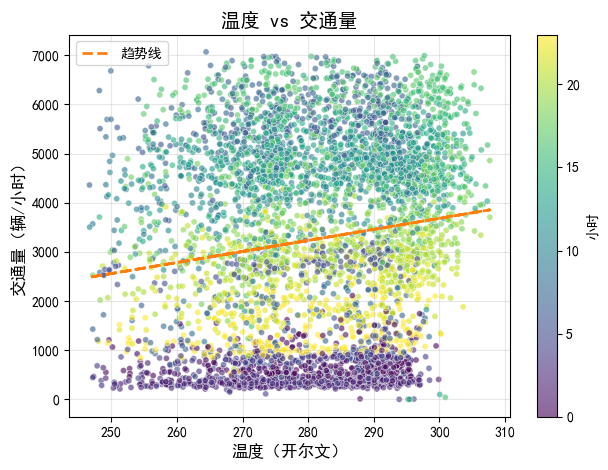

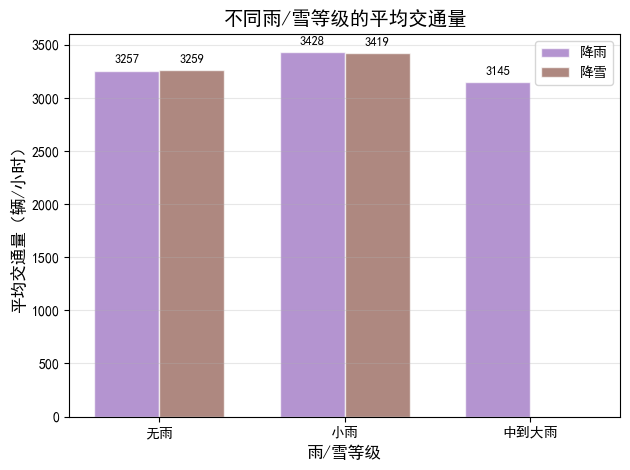

In [4]:
# 温度与交通量的关系

# 抽样5000个点避免拥挤
sample_df = df.sample(5000, random_state=42)
scatter1 = plt.scatter(
    sample_df['temp'], 
    sample_df['traffic_volume'], 
    c=sample_df['hour'], 
    cmap='viridis',
    alpha=0.6,
    s=20,
    edgecolors='white',
    linewidth=0.5
)

plt.title('温度 vs 交通量', fontweight='bold', fontsize=14)
plt.xlabel('温度（开尔文）', fontsize=12)
plt.ylabel('交通量（辆/小时）', fontsize=12)
plt.grid(alpha=0.3)
cbar1 = plt.colorbar(scatter1)
cbar1.set_label('小时', fontsize=10)

# 线性趋势线
z = np.polyfit(sample_df['temp'], sample_df['traffic_volume'], 1)
p = np.poly1d(z)
plt.plot(sample_df['temp'], p(sample_df['temp']), 
         color=colors_primary[1], linewidth=2, linestyle='--', label='趋势线')
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# 降雨量/降雪量与交通量的关系

rain_bins = [0, 0.1, 1, 10]
rain_labels = ['无雨', '小雨', '中到大雨']
df['rain_bin'] = pd.cut(
    df['rain_1h'], 
    bins=rain_bins, 
    labels=rain_labels,
    include_lowest=True
)

snow_bins = [0, 0.1, 1, 10]
snow_labels = ['无雪', '小雪', '中到大雪']
df['snow_bin'] = pd.cut(
    df['snow_1h'], 
    bins=snow_bins, 
    labels=snow_labels,
    include_lowest=True
)

# 计算平均交通量
rain_volume = df.groupby('rain_bin')['traffic_volume'].mean().reset_index()
snow_volume = df.groupby('snow_bin')['traffic_volume'].mean().reset_index()

rain_volume = rain_volume.set_index('rain_bin').reindex(rain_labels).reset_index()
snow_volume = snow_volume.set_index('snow_bin').reindex(snow_labels).reset_index()
rain_volume['traffic_volume'] = rain_volume['traffic_volume'].fillna(0)
snow_volume['traffic_volume'] = snow_volume['traffic_volume'].fillna(0)

x = np.arange(len(rain_volume))  
width = 0.35

# 绘制分组柱
bars1 = plt.bar(x - width/2, rain_volume['traffic_volume'], width, 
                label='降雨', color=colors_primary[4], alpha=0.7, edgecolor='white')
bars2 = plt.bar(x + width/2, snow_volume['traffic_volume'], width, 
                label='降雪', color=colors_primary[5], alpha=0.7, edgecolor='white')

# 图表美化与配置
plt.title('不同雨/雪等级的平均交通量', fontweight='bold', fontsize=14)
plt.xlabel('雨/雪等级', fontsize=12)
plt.ylabel('平均交通量（辆/小时）', fontsize=12)
plt.xticks(x, rain_volume['rain_bin'])  # 用降雨标签统一显示x轴
plt.legend(fontsize=10)
plt.grid(alpha=0.3, axis='y')

# 添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height + 50,
                     f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

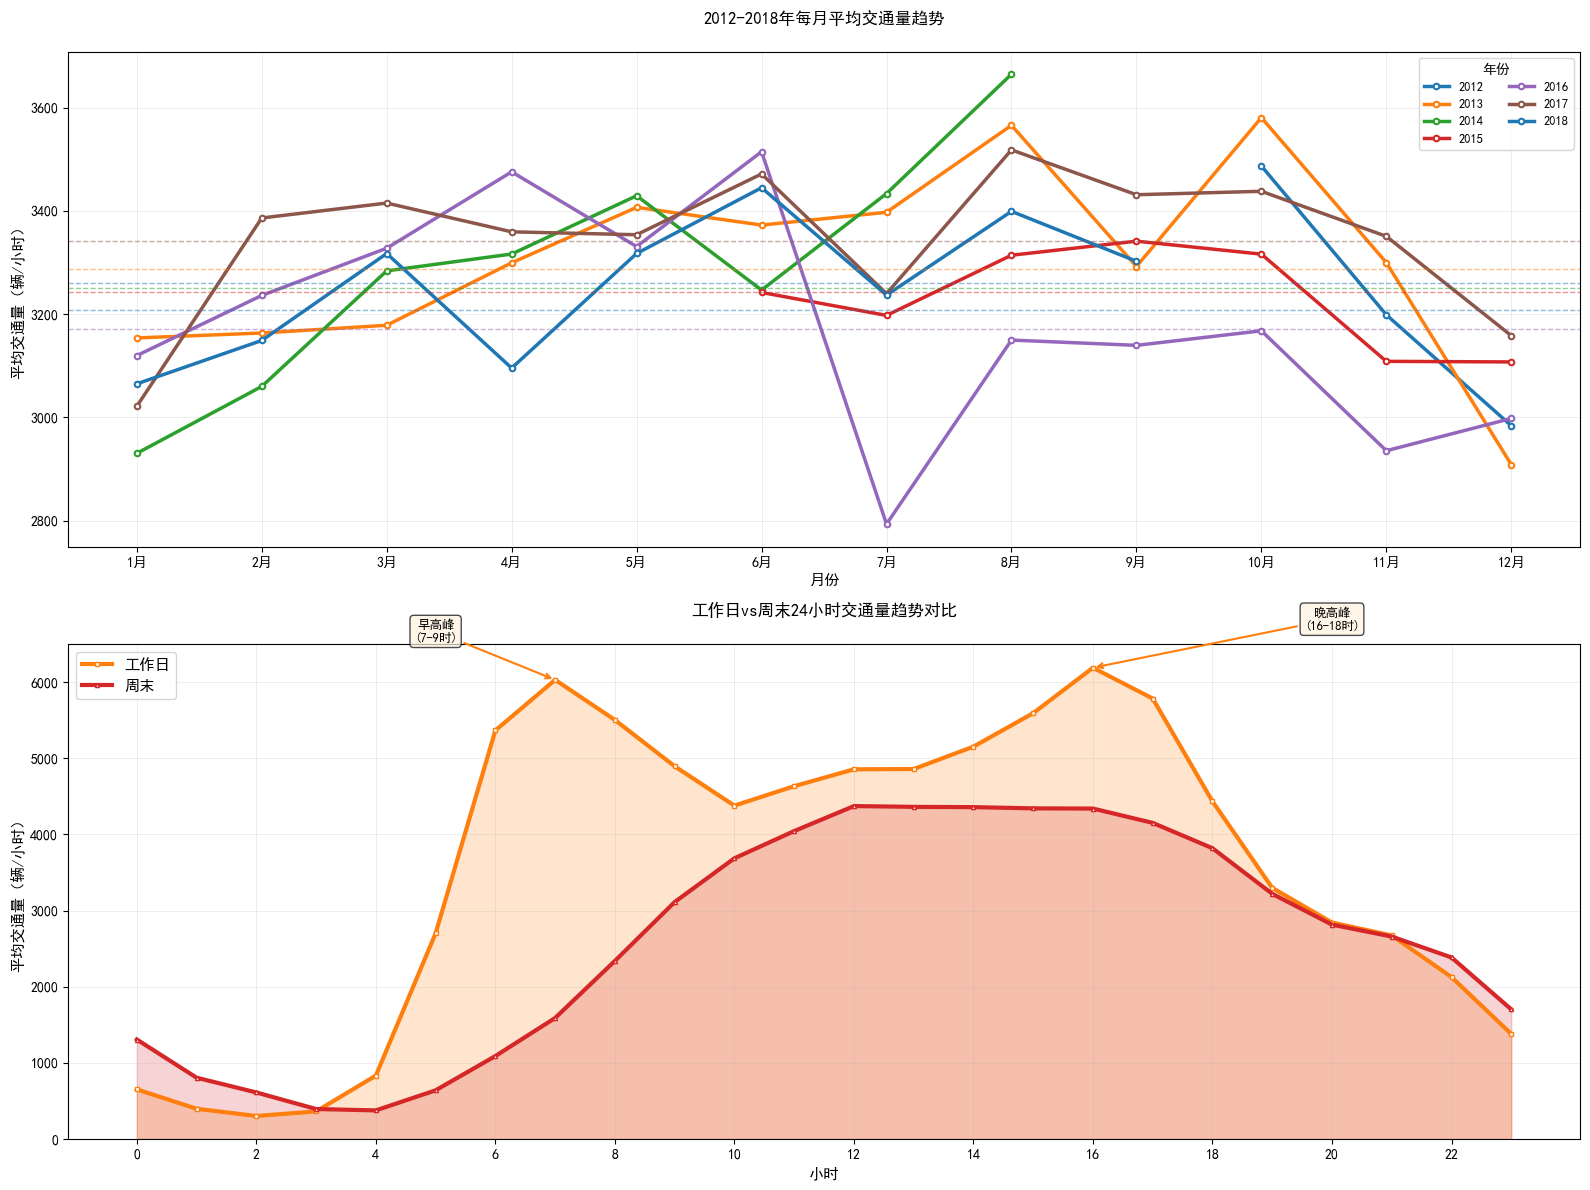

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 子图1：年度交通量趋势
yearly_monthly = df.groupby(['year', 'month'])['traffic_volume'].mean().reset_index()
years = sorted(df['year'].unique())
for i, year in enumerate(years):
    year_data = yearly_monthly[yearly_monthly['year'] == year]
    axes[0].plot(
        year_data['month'], 
        year_data['traffic_volume'],
        color=colors_primary[i % len(colors_primary)],  
        linewidth=2.5,
        marker='o',
        markersize=4,
        markerfacecolor='white',
        markeredgecolor=colors_primary[i % len(colors_primary)],
        markeredgewidth=1.5,
        label=str(year)
    )

axes[0].set_title('2012-2018年每月平均交通量趋势', fontweight='bold', pad=20)
axes[0].set_xlabel('月份', fontsize=11)
axes[0].set_ylabel('平均交通量（辆/小时）', fontsize=11)
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月'])
axes[0].grid(alpha=0.3, linestyle='-', linewidth=0.5)
axes[0].legend(loc='upper right', ncol=2, fontsize=9, title='年份', title_fontsize=10)  

overall_yearly = df.groupby('year')['traffic_volume'].mean()
for year, mean_val in overall_yearly.items():
    axes[0].axhline(y=mean_val, color=colors_primary[years.index(year) % len(colors_primary)], 
                   linestyle='--', linewidth=1, alpha=0.5)

# 子图2：工作日vs周末24小时交通量对比
# 定义工作日/周末标签
df['day_type'] = df['weekday'].apply(lambda x: '工作日' if x <= 4 else '周末')

hourly_daytype = df.groupby(['day_type', 'hour'])['traffic_volume'].mean().reset_index()
workday_data = hourly_daytype[hourly_daytype['day_type'] == '工作日']
weekend_data = hourly_daytype[hourly_daytype['day_type'] == '周末']

axes[1].plot(
    workday_data['hour'],
    workday_data['traffic_volume'],
    color=colors_primary[1],
    linewidth=3,
    marker='s',
    markersize=3,
    label='工作日',
    markerfacecolor='white',
    markeredgecolor=colors_primary[1]
)
axes[1].fill_between(
    workday_data['hour'],
    workday_data['traffic_volume'],
    alpha=0.2,
    color=colors_primary[1]
)
axes[1].plot(
    weekend_data['hour'],
    weekend_data['traffic_volume'],
    color=colors_primary[3],
    linewidth=3,
    marker='^',
    markersize=3,
    label='周末',
    markerfacecolor='white',
    markeredgecolor=colors_primary[3]
)
axes[1].fill_between(
    weekend_data['hour'],
    weekend_data['traffic_volume'],
    alpha=0.2,
    color=colors_primary[3]
)

axes[1].set_title('工作日vs周末24小时交通量趋势对比', fontweight='bold', pad=20)
axes[1].set_xlabel('小时', fontsize=11)
axes[1].set_ylabel('平均交通量（辆/小时）', fontsize=11)
axes[1].set_xticks(range(0, 24, 2))  
axes[1].set_ylim(bottom=0)  
axes[1].grid(alpha=0.3, linestyle='-', linewidth=0.5)
axes[1].legend(fontsize=11, loc='upper left')

# 标记关键时段（早高峰、晚高峰，移除未定义的colors_secondary）
axes[1].annotate('早高峰\n(7-9时)', xy=(7, workday_data[workday_data['hour']==7]['traffic_volume'].values[0]),
                xytext=(5, workday_data[workday_data['hour']==7]['traffic_volume'].values[0]+500),
                arrowprops=dict(arrowstyle='->', color=colors_primary[1], linewidth=1.5),
                ha='center', fontweight='bold', fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFF3E0', alpha=0.7))

axes[1].annotate('晚高峰\n(16-18时)', xy=(16, workday_data[workday_data['hour']==16]['traffic_volume'].values[0]),
                xytext=(20, workday_data[workday_data['hour']==16]['traffic_volume'].values[0]+500),
                arrowprops=dict(arrowstyle='->', color=colors_primary[1], linewidth=1.5),
                ha='center', fontweight='bold', fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFF3E0', alpha=0.7))

plt.tight_layout()
plt.show() 

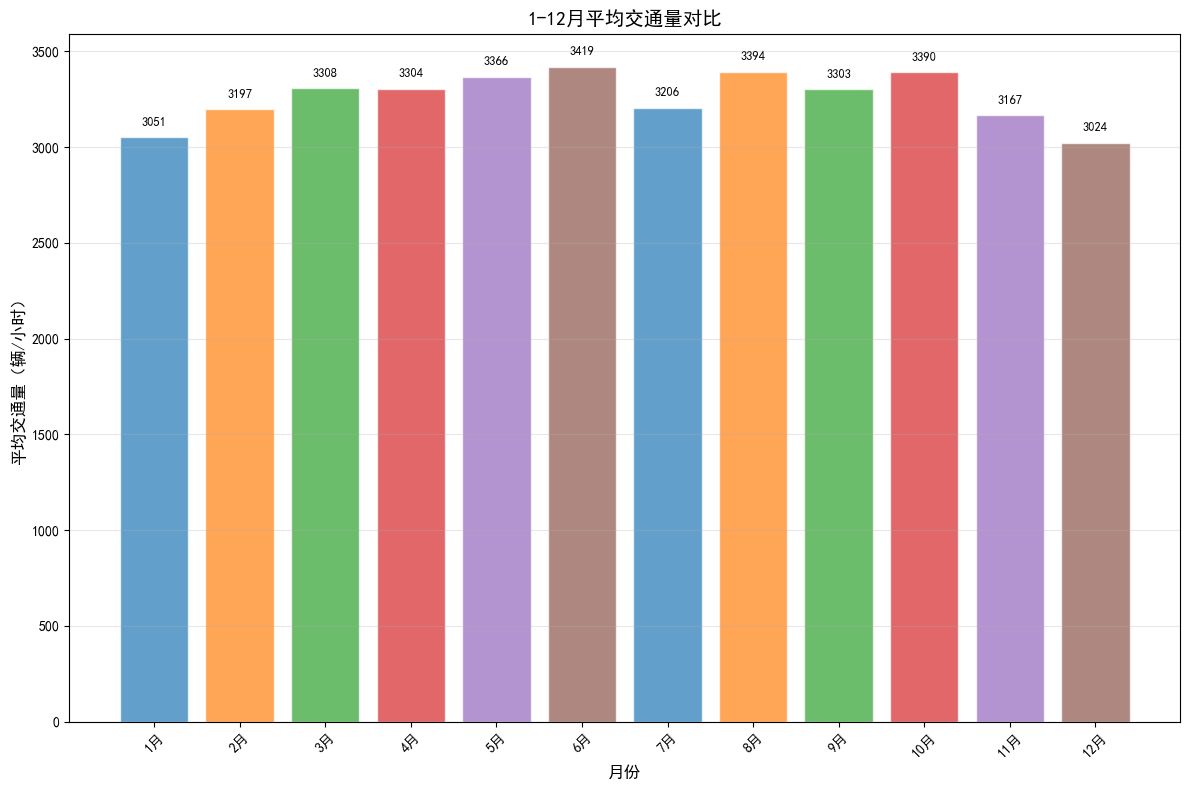

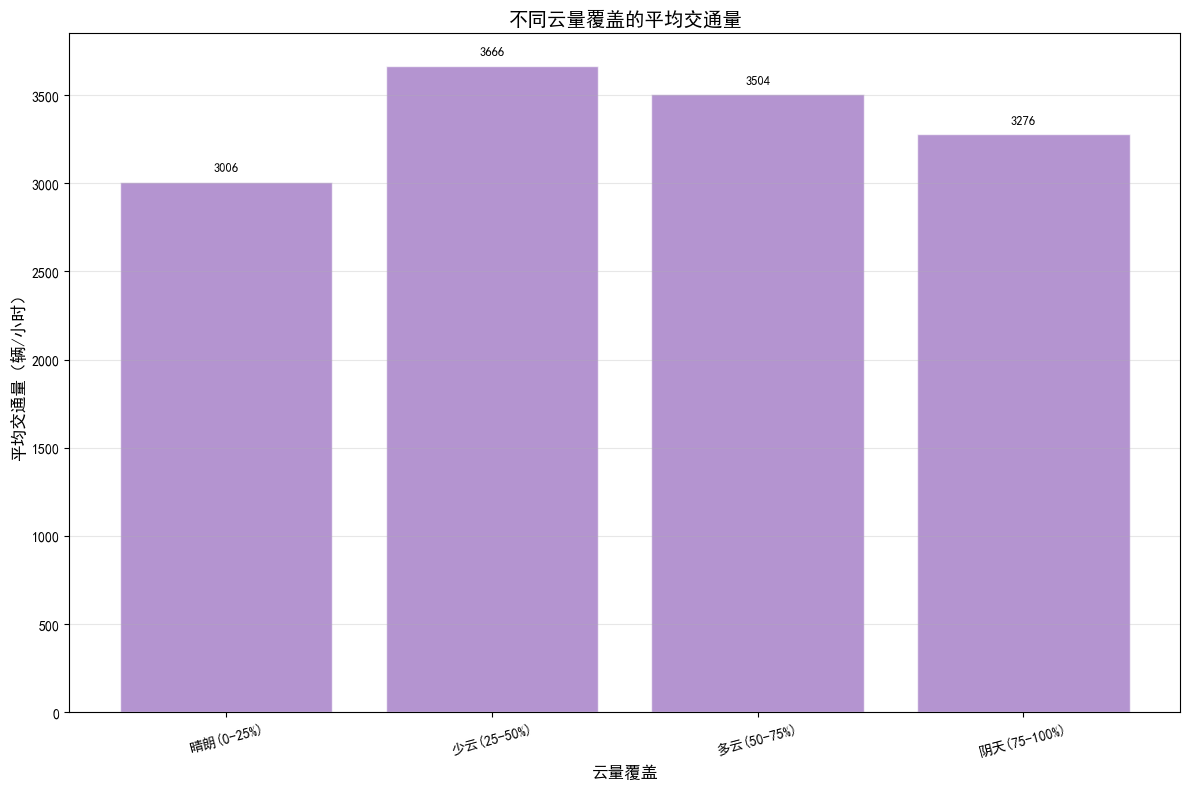

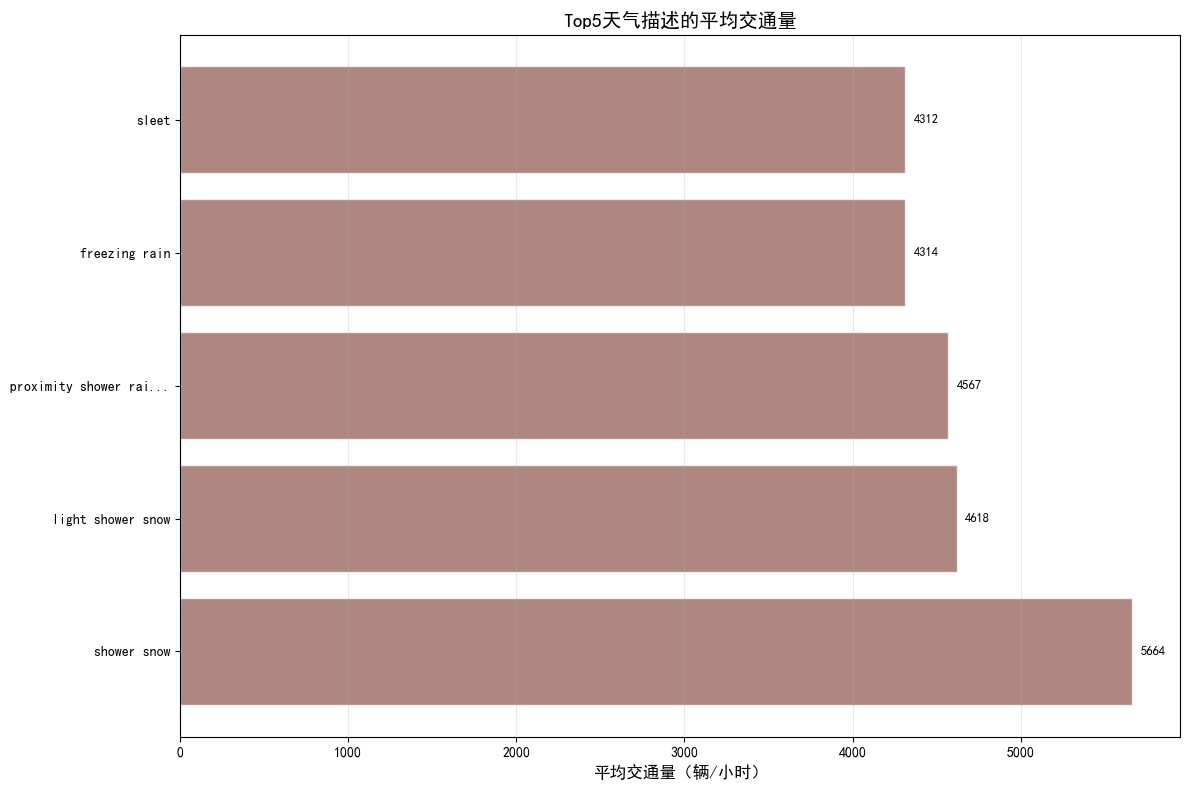

In [9]:
# 不同月份平均交通量对比
plt.figure(figsize=(12, 8))
monthly_volume = df.groupby(['month', 'month_cn'])['traffic_volume'].mean().reset_index()
# 按月份排序
month_order = list(range(1, 13))
monthly_volume['month'] = pd.Categorical(monthly_volume['month'], categories=month_order, ordered=True)
monthly_volume = monthly_volume.sort_values('month')

bars3 = plt.bar(
    monthly_volume['month_cn'],
    monthly_volume['traffic_volume'],
    color=[colors_primary[i % len(colors_primary)] for i in range(len(monthly_volume))],
    alpha=0.7,
    edgecolor='white'
)

plt.title('1-12月平均交通量对比', fontweight='bold', fontsize=14)
plt.xlabel('月份', fontsize=12)
plt.ylabel('平均交通量（辆/小时）', fontsize=12)
plt.xticks(rotation=45)  
plt.grid(alpha=0.3, axis='y')
plt.ylim(bottom=0)  

for bar in bars3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()  

# 云量覆盖与交通量关系
plt.figure(figsize=(12, 8))
df['clouds_bin'] = pd.cut(df['clouds_all'], bins=[0,25,50,75,100], labels=['晴朗(0-25%)','少云(25-50%)','多云(50-75%)','阴天(75-100%)'])
clouds_volume = df.groupby('clouds_bin')['traffic_volume'].mean().reset_index()
bars2 = plt.bar(clouds_volume['clouds_bin'], clouds_volume['traffic_volume'],
                color=colors_primary[4], alpha=0.7, edgecolor='white')

plt.title('不同云量覆盖的平均交通量', fontweight='bold', fontsize=14)
plt.xlabel('云量覆盖', fontsize=12)
plt.ylabel('平均交通量（辆/小时）', fontsize=12)
plt.xticks(rotation=15) 
plt.grid(alpha=0.3, axis='y')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


# Top5天气描述的交通量对比
plt.figure(figsize=(12, 8))
top_weather = df.groupby('weather_description')['traffic_volume'].mean().sort_values(ascending=False).head(5)
bars4 = plt.barh(range(len(top_weather)), top_weather.values,
                 color=colors_primary[5], alpha=0.7, edgecolor='white')

plt.title('Top5天气描述的平均交通量', fontweight='bold', fontsize=14)
plt.xlabel('平均交通量（辆/小时）', fontsize=12)
plt.yticks(range(len(top_weather)), [desc[:20]+'...' if len(desc)>20 else desc for desc in top_weather.index])
plt.grid(alpha=0.3, axis='x')

for i, bar in enumerate(bars4):
    width = bar.get_width()
    plt.text(width + 50, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

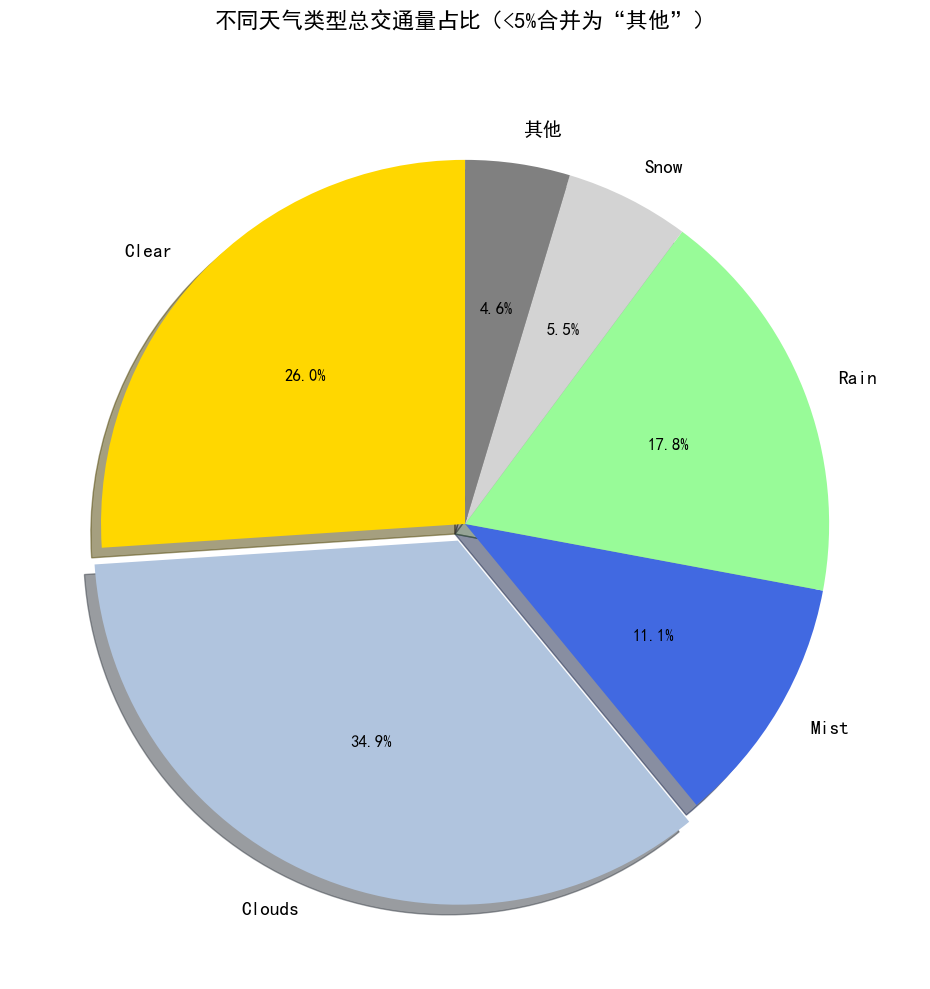

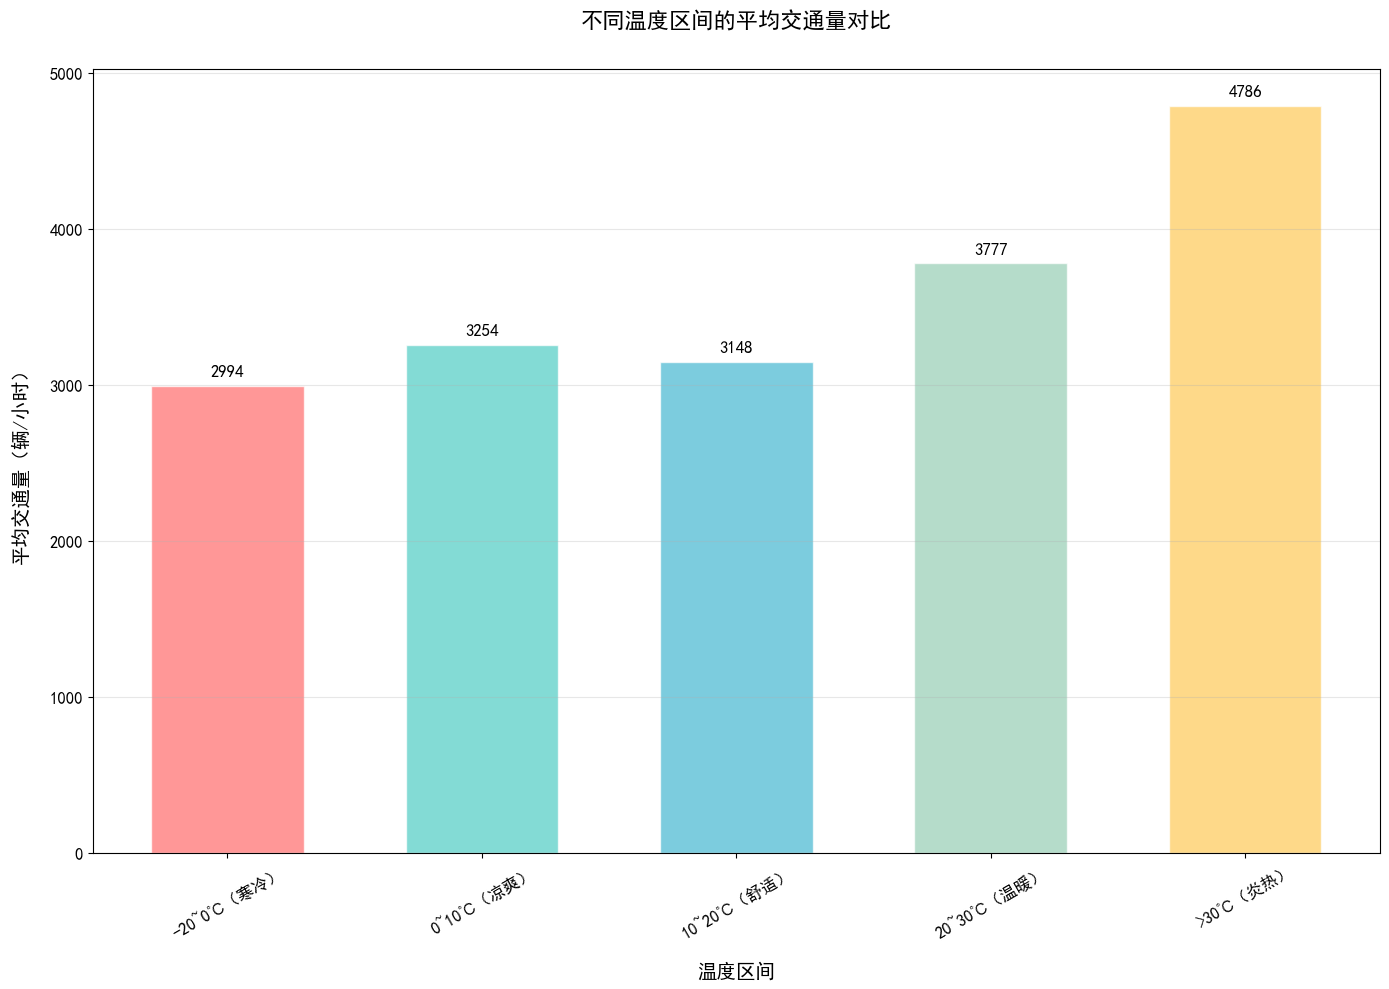

In [7]:
# 天气及温度对交通量的影响
plt.figure(figsize=(14, 10)) 
# 计算各天气类型的总交通量及占比
weather_total_volume = df.groupby('weather_simple')['traffic_volume'].sum().reset_index()
total_traffic = weather_total_volume['traffic_volume'].sum() 
weather_total_volume['proportion'] = (weather_total_volume['traffic_volume'] / total_traffic) * 100 

# 合并低占比（<5%）为“其他”
high_proportion_df = weather_total_volume[weather_total_volume['proportion'] >= 5.0].copy()
low_proportion_df = weather_total_volume[weather_total_volume['proportion'] < 5.0].copy()

if not low_proportion_df.empty:
    other_total = low_proportion_df['traffic_volume'].sum()
    other_proportion = (other_total / total_traffic) * 100
    final_weather_df = pd.concat([
        high_proportion_df,
        pd.DataFrame({
            'weather_simple': ['其他'],
            'traffic_volume': [other_total],
            'proportion': [other_proportion]
        })
    ], ignore_index=True)
else:
    final_weather_df = high_proportion_df.copy()

weather_labels = final_weather_df['weather_simple'].tolist()
weather_volumes = final_weather_df['traffic_volume'].tolist()
unique_weather_colors = [
    '#FFD700', '#B0C4DE', '#4169E1', '#98FB98', '#D3D3D3',
    '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57',
    '#FF9F43', '#6C5CE7', '#A29BFE', '#00B894', '#E17055'
]

weather_pie_colors = unique_weather_colors[:len(weather_labels)]
if '其他' in weather_labels:
    other_index = weather_labels.index('其他')
    weather_pie_colors[other_index] = '#808080' 
    
explode = [0.05 if vol == max(weather_volumes) else 0 for vol in weather_volumes]

wedges, texts, autotexts = plt.pie(
    weather_volumes,
    labels=weather_labels,
    colors=weather_pie_colors,
    explode=explode,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    textprops={'fontsize': 14, 'fontweight': 'bold'}  
)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)  

plt.title('不同天气类型总交通量占比（<5%合并为“其他”）', 
          fontweight='bold', fontsize=16, pad=30) 

plt.tight_layout()
plt.show() 

# 温度分段的平均交通量对比
plt.figure(figsize=(14, 10))
# 温度单位转换
df['temp_celsius'] = df['temp'] - 273.15

# 分箱配置
temp_bins = [-20, 0, 10, 20, 30, 40]
temp_labels = ['-20~0℃（寒冷）', '0~10℃（凉爽）', '10~20℃（舒适）', '20~30℃（温暖）', '>30℃（炎热）']
df['temp_bin'] = pd.cut(
    df['temp_celsius'],
    bins=temp_bins,
    labels=temp_labels,
    include_lowest=True
)

temp_volume = df.groupby('temp_bin')['traffic_volume'].mean().dropna().reset_index()
unique_temp_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9F43', '#6C5CE7']
temp_bar_colors = unique_temp_colors[:len(temp_volume)]

bars = plt.bar(
    temp_volume['temp_bin'],
    temp_volume['traffic_volume'],
    color=temp_bar_colors,
    alpha=0.7,
    edgecolor='white',
    width=0.6
)

plt.title('不同温度区间的平均交通量对比', fontweight='bold', fontsize=16, pad=30)  
plt.xlabel('温度区间', fontsize=14, labelpad=15)  
plt.ylabel('平均交通量（辆/小时）', fontsize=14, labelpad=15)  

plt.xticks(rotation=30, fontsize=12)  
plt.yticks(fontsize=12)

plt.grid(alpha=0.3, axis='y')
plt.ylim(bottom=0)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 50,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=12 
    )

plt.tight_layout()
plt.show()  